## The Truth about Fake News: Using Text Analysis to Determine Credibility and Patterns

Ana Caklovic (134), Samantha Dalal (134), Shireen Mann (134), Sarah Hermann (134)

UCSB BOX Link to access notebook & data set because our datafile is over 100 MB: 

https://ucsb.box.com/s/we1ugm5vafl4s3rhyxr0wzgj66sqjeka

Data set used in project is originally from Kaggle: https://www.kaggle.com/c/fake-news/overview

### INTRODUCTION

Fake news is created to intentionally misinform or deceive the readers. It often catches their attention and leads them to read something that is biased, skewed or deceitful. The articles or sites often look credible, causing people to read and believe. It has become much easier for people to create fake news as almost anyone with internet access can post an article and make it harder for people to determine if news is fake or not. Our project examines news articles in the U.S. and investigates the characteristics and patterns of fake news. We use the title of the article as well as the text to determine if the source that published the article is reliable or not reliable. 


### DATASET

The data set we used from kaggle.com contains the following information: id -  unique id for a news article, title - the title of a news article, author - author of the news article, text - the text of the article; could be incomplete, and label - a label that marks the article as potentially unreliable (1: unreliable, 0: reliable). 

### APPROACH (goals) 

We will use text analysis and natural language processing to see if we can determine how credible a news source is. Our goal is to be able to correctly label “fake news” with our model with a relatively high level of accuracy. Additionally, we will find the frequency of certain words associated with “fake news,” and sentiments associated with the words and “fake news.”


### METHODS: (procedure/steps we took)

- Cleaned the data by removing contractions, stop words, small words, etc to create a data set that would produce better, cleaner results from our analysis. 

- Used TF-IDF and countvectorizer to identify the most relevant words in the corpus while also removing stop words and words that occur in over 70% of the articles. 

- Created a NMF based on 3, 5 or 10 topics with 19 or 20 words in each topic.

- Examined articles 8026 and 11507 together to compare their similarities between topics. Article 8026’s topics were then used to look at how closely other topics related to its topics.

- Constructed confusion matrices for the text and title of the articles and looked at the relative accuracy of the models using different combinations TF-IDF, countvectorizer, naive bayes, and the title or text of the articles.

- Receiver operating characteristic (ROC) graphs were used to compare the confusion matrices created above for title and text.

- Performed sentiment analysis on the text as well as the titles and used the compound scores to create visualizations to interpret the results (see below).


In [1]:
!pip install nltk

In [2]:
!pip install pandas_datareader

In [3]:
import numpy as np
import pandas_datareader as dr
import pandas as pd
import matplotlib.pyplot as plt
#import myAPIkeys as m

# download dictionary of stop words
import nltk
nltk.download('stopwords')
nltk.download('punkt') # tokenizer

# import necessary modules
import re
import string
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHUBHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SHUBHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

## Upload the Data

 - We will import the dataset: a training set and a test set
 - These come from a corpus on Kaggle, which has compiled articles and recorded their titles, authors, id, labels and the text itself.
     - Labels: mark the article as potentially reliable (0) or unreliable (1)
     - ID: each article has a unique identification number

In [5]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [6]:
train_data.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

### Tokenize the data

In [21]:
text = train_data['text']
print(text)

0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        Ever get the feeling your life circles the rou...
2        Why the Truth Might Get You Fired October 29, ...
3        Videos 15 Civilians Killed In Single US Airstr...
4        Print \nAn Iranian woman has been sentenced to...
                               ...                        
20795    Rapper T. I. unloaded on black celebrities who...
20796    When the Green Bay Packers lost to the Washing...
20797    The Macy’s of today grew from the union of sev...
20798    NATO, Russia To Hold Parallel Exercises In Bal...
20799      David Swanson is an author, activist, journa...
Name: text, Length: 20800, dtype: object


In [22]:
def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

In [24]:
print(tokenize_text)

<function tokenize_text at 0x00000215F146A5C0>


### Remove contractions

In [16]:
def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        # not sure why below is there
        # expanded_contraction = first_char+expanded_contraction[1:] 
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

### Remove stopwords

In [17]:
from sklearn.feature_extraction._stop_words  import ENGLISH_STOP_WORDS

#ENGLISH_STOP_WORDS

In [18]:
def remove_stopwords(text,stopword_list):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

### Remove special characters

In [19]:
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

#### Apply the functions

In [25]:
text1 = train_data['text'].apply(remove_stopwords, stopword_list=(list(ENGLISH_STOP_WORDS)))

TypeError: expected string or bytes-like object, got 'float'

In [12]:
#text2 = text1.apply(remove_special_characters)

In [13]:
#text3 = text2.apply(tokenize_text)

#### Add the new cleaned data to the original dataframe

In [14]:
#train_data['cleaned data'] = text2

In [15]:
#Preview the dataset with the appended column
#train_data.head()

In [16]:
def keep_text_characters(text):
    filtered_tokens = []
    tokens = tokenize_text(text)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def normalize_text(text,tokenize=False):
    text = expand_contractions(text, CONTRACTION_MAP)
    text = lemmatize_text(text)
    text = remove_special_characters(text)
    text = text.lower()
    text = remove_stopwords(text,ENGLISH_STOP_WORDS)
    text = keep_text_characters(text)

    return text

from nltk import pos_tag
from nltk.corpus import wordnet as wn

# Annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None

    tagged_text = pos_tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text

# lemmatize text based on POS tags    
def lemmatize_text(text):
    text = tokenize_text(text)
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

#### Takes too long to run, so save the new dataframe as a csv and read it back in

In [17]:
clean_train_data = pd.read_csv("final_df3.csv")

In [18]:
clean_train_data.drop(columns=["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1"]).head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                        cleaned_text  \
0  House Dem Aide We Didn ’ t Even See Comey ’ s ...   
1  Ever feeling life circles roundabout heads str...   
2  Why Truth Might Get You Fired October 29 2016 ...   
3  Videos 15 Civilians Killed In Single US Airstr...   
4  Print An Iranian woman sentenced years prison ...   

                                        cleaned_data  \
0  house dem aide didn t comey s letter jason cha...   
1  feel life circle roundabout head straight line...   
2  truth october tension intelligence analyst pol...   
3  video civilian killed single u airstrike ident...   
4  print iranian woman sentence year prison iran ...   

                                       cleaned_title  
0  house dem aide didn t comey s letter jason cha...  
1   flynn hillary clinton big woman campus breitbart  
2                                              truth  
3        civilian kill single u airstrike identified  
4  iranian woman jail fictional unpublished story...

In [19]:
clean_train_data.label.mean() # proportion between fake and real articles

0.500625

#### Drop the NA values

In [20]:
cleaned_df = clean_train_data.dropna(axis=0)
#or
#nans = lambda final_df: final_df[final_df.isnull().any(axis=1)]

In [21]:
y = cleaned_df.copy() # make a copy of the data frame

### Train, test, split

Divide the newly cleaned data into a training set and a testing set.

In [22]:
###### train test split for body (the text of the article)

new_df = cleaned_df.copy()
new_df = new_df.set_index("Unnamed: 0") # set index of dataframe
#new_df.head()
y_new = new_df.label
#y_new.head()
new_df.drop("label", axis =1)

X_train, X_test, y_train, y_test = train_test_split(new_df['cleaned_data'], y_new, test_size=0.33, random_state=53)
X_train.head()

Unnamed: 0
14746    october parent group pet zoo outrage report ex...
14989    phoenix invitation border mayor meet land inbo...
7659     prev swipe leftright twitter look future read ...
2207     thursday jurgen klinsmann coach united state n...
19540    donald trump expect position offer united king...
Name: cleaned_data, dtype: object

In [23]:
y_train.head()

Unnamed: 0
14746    1
14989    0
7659     1
2207     0
19540    0
Name: label, dtype: int64

In [24]:
###### train test split for headlines(the title of the article)

X_train2, X_test2, y_train2, y_test2 = train_test_split(new_df['title'], y_new, test_size=0.33, random_state=53)
X_train2.head()

Unnamed: 0
14746         Gove criticised for leaving Boris unattended
14989    Bilingual Invitation to Arizona Mayor Draws an...
7659     Twitter has been looking into the future: read...
2207     Jurgen Klinsmann Fired as U.S. Soccer Coach - ...
19540    Top Trump Adviser: UK/U.S. Deal Could Be Ready...
Name: title, dtype: object

In [25]:
y_train2.head() 

Unnamed: 0
14746    1
14989    0
7659     1
2207     0
19540    0
Name: label, dtype: int64

Article explaining what we are doing with vecorization: https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html

"In order to perform machine learning on text, we need to transform our documents into vector representations such that we can apply numeric machine learning. This process is called feature extraction or more simply, vectorization, and is an essential first step toward language-aware analysis."

In [32]:
# Use tf-idf and count vectorizer to find most relevant words in corpus
# TfidfVectorizer should remove stop words and words that appear in more than 70% of the articles   

### TF-IDF vs. Count Vectorizer
In text analysis, count vectorizer and TF-IDF are two methods used for counting words in the text. While the count vectorizer method, also known as Bag of Words, simply counts the frequency of each word, TF-IDF, or term frequency-inverse document frequency, measures the frequency of words in terms of all documents in a corpus.

Below, we will compare both of these methods for analysis of both the text of articles and their headlines. 

#### TF-IDF and COUNT VECTORIZER for text (the body of the article)

In [32]:
# TF-IDF for the text
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english') # already gets rid of stop words
count_train = count_vectorizer.fit_transform(X_train) 
count_test = count_vectorizer.transform(X_test)

In [33]:
# COUNT VECTORIZER for the text 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)  
tfidf_test = tfidf_vectorizer.transform(X_test)

In [34]:
# Get the feature names of `tfidf_vectorizer`
print(tfidf_vectorizer.get_feature_names()[-10:])

['švercl', 'źródeł', 'żadnym', 'że', 'żeby', 'żołnierzy', 'życia', 'żądaniu', 'տlіӎ', 'ﬁnds']


In [35]:
# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['00017b2908ff9fa45188d243fd49aaeeb2dhrcofficecom', '0005s', '0006s', '0007s', '0008s', '000c', '000s', '000th', '001s', '0023z']


#### TF-IDF and COUNT VECTORIZER for headlines (the title of the article)

In [36]:
# TF-IDF for the title
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer2 = CountVectorizer(stop_words='english') # already gets rid of stop words
count_train2 = count_vectorizer.fit_transform(X_train2) 
count_test2 = count_vectorizer.transform(X_test2)

In [37]:
# COUNT VECTORIZER for the title 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.7) 
tfidf_train2 = tfidf_vectorizer.fit_transform(X_train2)  
tfidf_test2 = tfidf_vectorizer.transform(X_test2)

### Compare the Accuracy Rates of the Models with Confusion Matrix

In order to see whether bag of words or tf-idf is the more efficient method, we can use scikit-learn to build confusion matrices to compare the models. A confusion matrix is a method to determine the accuracy of predictions, which we can use to determine an optimal model for our analysis.

In [38]:
# source: https://github.com/venkateshgupta5/Fake-News/blob/master/Fake%20News%20Classifier.ipynb
# more at: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
            horizontalalignment="center",
            color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Multinomial Naive Bayes:
##### First compare models for the text

accuracy: 0.729
Confusion matrix, without normalization


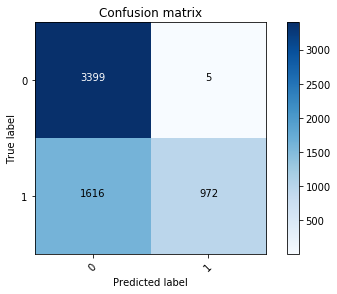

In [39]:
# Confusion Matrix with NB + tf-idf --> for the text
mn_tfidf_cf = MultinomialNB()
mn_tfidf_cf.fit(tfidf_train, y_train)
pred = mn_tfidf_cf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

In [40]:
# Confusion Matrix with NB + Count Vectorizer (bag of words) --> for the text
mn_count_cf = MultinomialNB()
mn_count_cf.fit(count_train, y_train)
pred = mn_count_cf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

accuracy: 0.917
Confusion matrix, without normalization


##### Then compare models using headlines

In [41]:
# Confusion Matrix with NB + tf-idf ---> for the title
mn_tfidf_cf2 = MultinomialNB()
mn_tfidf_cf2.fit(tfidf_train2, y_train2)
pred = mn_tfidf_cf2.predict(tfidf_test2)
score = accuracy_score(y_test2, pred)
print("accuracy: %0.3f" % score)
cm = confusion_matrix(y_test2, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

accuracy: 0.844
Confusion matrix, without normalization


accuracy: 0.897
Confusion matrix, without normalization


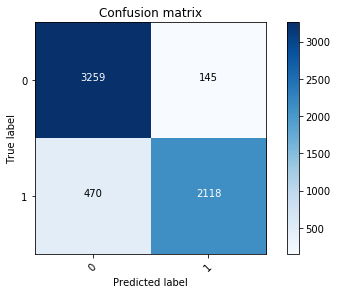

In [42]:
# Confusion Matrix with NB + Count Vectorizer ---> for the title
mn_count_cf2 = MultinomialNB()
mn_count_cf2.fit(count_train2, y_train2)
pred = mn_count_cf2.predict(count_test2)
score = accuracy_score(y_test2, pred)
print("accuracy: %0.3f" % score)
cm = confusion_matrix(y_test2, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

When it came to using multinomial naive bayes, the model with the highest accuracy for text used count vectorizer/bag of words (accuracy = 0.917) and the model with the highest accuracy for title used count vectorizer/bag of words (accuracy = 0.897).

#### Logistic Regression:

Next, we run the tf-idf and count vectorizers with a logistic regression model to see if it performs better than a multinomial bayes model. Linear models have been suggested to work well for text data ([scikit-learn text analysis](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#evaluation-of-the-performance-on-the-test-set)).

##### First on the text

In [43]:
# Confusion Matrix with Logistic Regression + tf-idf --> for the text
from sklearn.linear_model import LogisticRegression

lr_tfidf_cf = LogisticRegression()
lr_tfidf_cf.fit(tfidf_train, y_train)
pred = lr_tfidf_cf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 0.944
Confusion matrix, without normalization


In [44]:
# Confusion Matrix with Logistic Regression + Count Vectorizer (bag of words) --> for the text

lr_count_cf = LogisticRegression()
lr_count_cf.fit(count_train, y_train)
pred = lr_count_cf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

accuracy: 0.947
Confusion matrix, without normalization


##### Then on the headlines

accuracy: 0.922
Confusion matrix, without normalization


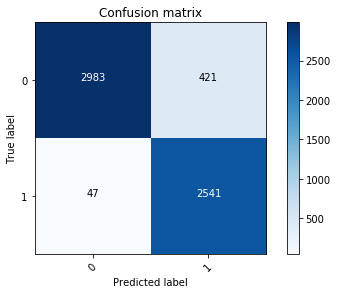

In [45]:
# Confusion Matrix with Logistic Regression + tf-idf ---> for the title
lr_tfidf_cf2 = LogisticRegression()
lr_tfidf_cf2.fit(tfidf_train2, y_train2)
pred = lr_tfidf_cf2.predict(tfidf_test2)
score = accuracy_score(y_test2, pred)
print("accuracy: %0.3f" % score)
cm = confusion_matrix(y_test2, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

accuracy: 0.930
Confusion matrix, without normalization


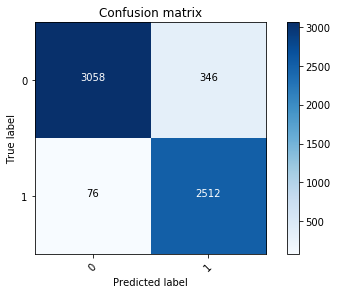

In [46]:
# Confusion Matrix with Logistic Regression + Count Vectorizer ---> for the title
lr_count_cf2 = LogisticRegression()
lr_count_cf2.fit(count_train2, y_train2)
pred = lr_count_cf2.predict(count_test2)
score = accuracy_score(y_test2, pred)
print("accuracy: %0.3f" % score)
cm = confusion_matrix(y_test2, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

When it came to using logistic regression, the model with the highest accuracy for text used count vectorizer/bag of words (accuracy = 0.947) and the model with the highest accuracy for title used count vectorizer/bag of words (accuracy = 0.930).

#### A summary of all of the model accuracy rates can be seen below:

Models for **Text**:
- Multinomial Bayes with TF-IDF: 0.729 accuracy
- Multinomial Bayes with Count Vectorizer: 0.917 accuracy
- Logistic Regression with TF-IDF: 0.944 accuracy
- Logistic Regression with Count Vectorizer: **0.947** accuracy → highest accuracy

Models for **Title**:
- Multinomial Bayes with TF-IDF: 0.844 accuracy
- Multinomial Bayes with Count Vectorizer: 0.897 accuracy
- Logistic Regression with TF-IDF: 0.922 accuracy
- Logistic Regression with Count Vectorizer: **0.930** accuracy → highest accuracy

Before conclusively decide which model is truly the most accuate for our dataset, we will We check the validity of our two highest accuracy models by looking at a reliable and unreliable article to see if the labels for the articles line up with the models' results:

- The unreliable article: Index # 17716 
- The reliable article: Index # 3625

We can see the true labels for both of the articles:

In [47]:
# Unreliable article: Index # 17716 
cleaned_df.loc[(cleaned_df['id'] == 17716)]

# We can see the label = 1 (unreliable)

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1     id  \
17716       17716         17716           17716  17716   

                                                   title     author  \
17716  FBI FOUND "TENS OF THOUSANDS OF EMAILS" BELONG...  newsguy76   

                                                    text  label  \
17716  Home › POLITICS › FBI FOUND “TENS OF THOUSANDS...      1   

                                            cleaned_text  \
17716  Home › POLITICS › FBI FOUND “ TENS OF THOUSAND...   

                                            cleaned_data  \
17716  home politics fbi thousand email belonging hum...   

                                           cleaned_title  
17716  fbi thousand email belonging huma abedin weine...

In [48]:
# Reliable article: Index # 3625
cleaned_df.loc[(cleaned_df['id'] == 3625)]

# We can see the label = 0 (reliable)

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1    id  \
3625        3625          3625            3625  3625   

                                                  title            author  \
3625  Mike Pence May Break With Donald Trump, Again,...  Yamiche Alcindor   

                                                   text  label  \
3625  COLUMBUS, Ind.  —   Gov. Mike Pence of Indiana...      0   

                                           cleaned_text  \
3625  COLUMBUS Ind — Gov Mike Pence Indiana Republic...   

                                           cleaned_data  \
3625  columbus ind gov mike penny indiana republican...   

                                          cleaned_title  
3625  mike penny break donald trump tax return new y...

We can see above the true labels for the two articles. Below is the model results for the two articles. First we will examine the model for text: Logistic Regression with Count Vectorizer.

In [49]:
# Confusion Matrix with Logistic Regression + Count Vectorizer ---> for the text
lr_count_cf = LogisticRegression()
lr_count_cf.fit(count_train, y_train)
pred = lr_count_cf.predict(count_test)
score = accuracy_score(y_test, pred)

In [50]:
print("predicted label for article 17716: %0.3f" %pred[0]) # in the prediction list, for first article mentioned is 17716
print("predicted label for article 3625: %0.3f" %pred[1]) # in the prediction list, for second article mentioned is 3625

predicted label for article 17716: 1.000
predicted label for article 3625: 0.000


The model results show that article 17716 was correctly labeled as unreliable (label = 1), and article 3625 was correctly labeled as reliable (label = 0). This shows that our model is accurate in this example.

Next, we will examine the model for title: also Logistic Regression with Count Vectorizer. 

In [51]:
# Confusion Matrix with Logistic Regression + Count Vectorizer ---> for the title
lr_count_cf2 = LogisticRegression()
lr_count_cf2.fit(count_train2, y_train2)
pred = lr_count_cf2.predict(count_test2)
score = accuracy_score(y_test2, pred)

In [52]:
print("predicted label for article 17716: %0.3f" %pred[0]) # in the prediction list, for first article mentioned is 17716
print("predicted label for article 3625: %0.3f" %pred[1]) # in the prediction list, for second article mentioned is 3625

predicted label for article 17716: 1.000
predicted label for article 3625: 0.000


The model results show that article 17716 was correctly labeled as unreliable (label = 1), and article 3625 was correctly labeled as reliable (label = 0). This shows that our model is accurate in this example.

These cross-validation results shows that our models are correctly labeling the articles most of the time. Please note that we used these two articles as an example; we also cross-checked accuracy with several other articles but did not put the examples in for the sake of not being repetitive.

By analyzing all of the models above, we can conclude:
- When it came to both the text and title of the articles, we had the highest accuracy when using a logistic regression with count vectorizer (bag of words) model.
- When it came to mistakes in labeling, all of our models were more likely to label an article as reliable when it was unreliable, rather than giving a false positive (labeling a reliable article as unreliable). This is actually promising since we are dealing with a fake news problem, which means we want to be very careful about labeling real news as fake. In addition, we can see that the model with least accuracy was the multinomial bayes with tf-idf. This model, in comparison to the others, was more likely to predict that an article was reliable when it was in fact unreliable. 

### Visually Compare the Models with ROC Curves
- The ROC curves compare the models run by each confusion matrix. The x-axis represents the probability that the article was falsely predicted, while the y-axis represents the probability the article was predicted correctly. So the best points are the ones that are in the upper left corner as they are positive and have the lowest probability that they were predicted incorrectly (negative).

#### ROC Curves for Text Models

0.9736851544777758
0.9690055748578363
0.9843558446558918
0.986854723145967


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

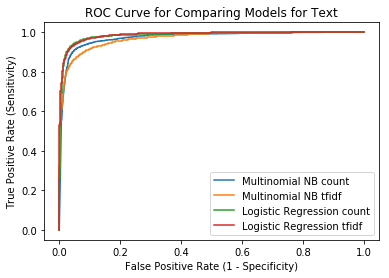

In [53]:
# Source: https://github.com/docketrun/Detecting-Fake-News-with-Scikit-Learn/blob/master/Comparing%20Fake%20News%20Classifiers.ipynb

# ROC to compare models for TEXT

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
plt.figure(0).clf()


for model, name in [ (mn_count_cf, 'Multinomial NB count'),
                     (mn_tfidf_cf, 'Multinomial NB tfidf'),
                     (lr_count_cf, 'Logistic Regression count'),
                     (lr_tfidf_cf, 'Logistic Regression tfidf')]:
    if 'count' in name:
        pred = model.predict_proba(count_test)[:,1]
    elif 'Multinomial' in name:
        pred = model.predict_proba(tfidf_test)[:,1] 
    else: 
        pred = model.decision_function(tfidf_test)
    fpr, tpr, thresh = metrics.roc_curve(y_test.values, pred)
    plt.plot(fpr,tpr,label="{}".format(name))
    print(metrics.auc(fpr, tpr))


plt.legend(loc=0) 
plt.title("ROC Curve for Comparing Models for Text")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")

Above, we see that the Multinomial Naive Bayes/TF-IDF model seems to perform the worst, while both of the Logistic Regression models seem to perform the best. Since the models are still rather close in regards to accuracy, we shall look at the areas under the curves to better compare:

Areas Under the Curves:
- Multinomial Bayes with Count Vectorizer: 0.9736851544777758
- Multinomial Bayes with TF-IDF: 0.9690055748578363
- Logistic Regression with Count Vectorizer: 0.9843533473665856
- Logistic Regression with TF-IDF: **0.986854723145967** → largest area

We find that the Logistic Regression Model with TF-IDF performs the best, since it has the largest area under the ROC curve.


#### ROC Curves for Title Models

In [54]:
# Source: https://github.com/docketrun/Detecting-Fake-News-with-Scikit-Learn/blob/master/Comparing%20Fake%20News%20Classifiers.ipynb

# ROC to compare models for TITLE

from sklearn import metrics
plt.figure(0).clf()


for model, name in [ (mn_count_cf2, 'Multinomial NB count'),
                     (mn_tfidf_cf2, 'Multinomial NB tfidf'),
                     (lr_count_cf2, 'Logistic Regression count'),
                     (lr_tfidf_cf2, 'Logistic Regression tfidf')]:
    if 'count' in name:
        pred = model.predict_proba(count_test2)[:,1]
    elif 'Multinomial' in name:
        pred = model.predict_proba(tfidf_test2)[:,1] 
    else: 
        pred = model.decision_function(tfidf_test2)
    fpr, tpr, thresh = metrics.roc_curve(y_test2.values, pred)
    plt.plot(fpr,tpr,label="{}".format(name))
    print(metrics.auc(fpr, tpr))

plt.legend(loc=0) 
plt.title("ROC Curve for Comparing Models for Title")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")

0.9744068710872016
0.9633710091046628
0.9780035352535521
0.9780155676474809


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

Again we find that the Multinomial Naive Bayes/TF-IDF model seems to perform the worst, while both Logistic Regression models appear to tie for being the best. So we will compare the areas under each curve to determine which model is best:

Areas Under the Curves:
- Multinomial Bayes with Count Vectorizer: 0.9744068710872016
- Multinomial Bayes with TF-IDF: 0.9633710091046628
- Logistic Regression with Count Vectorizer: **0.9780035352535521** → largest area
- Logistic Regression with TF-IDF: 0.9780155676474809 

We now find that Logistic Regression with Count Vectorizer is the most accurate model when using titles of the articles. This may be due to the fact that there are fewer words in headlines.

### NMF

In [55]:
#use article 20785 as real news example
clean_train_data.iloc[20785]
clean_train_data.iloc[20785]["cleaned_data"]

'sentence congress obamacare repeal read shall free market health insurance right ve solved health insurance crisis percent american unfortunately imagine free market health care look like haven t nearly century nbc s meet press weekend example chuck todd tell sen tom cotton proposal create affordable health care widely available sound good understand people think s impossible promise understand formulation condescension reserve conservative disagreement liberal sign stupidity todd continue make affordable make wider mean just like know like sell t realistically dream sequence chuck todd russia s meet press fall soviet union understand people think s impossible promise make bread affordable make wider mean just like know like sell t realistically turn outside communist dictatorship sort product affordable widely available don t need congress provide health care need provide bread need health insurance available free market lots company compete business basic health insurance cost month

In [56]:
#use as fake news example
clean_train_data.iloc[12]
clean_train_data.iloc[12]["cleaned_data"]

'mystery surround reich nazi germany subject debate observer believe nazi germany control adolf hitler possess supernatural power largely employed pseudoscience period hold belief just mere speculation prove fact year researcher search extensively answer mysterious activity associate nazi germany nazi germany invade russia ussr second world war june time german army progress deep russian territory gain ground close capital moscow russian counterattack eventually drive nazi nazi occupation russia nazi build secret military base arctic codenamed schatzgraber treasure hunter reportedly instrumental war russia base primarily use tactical weather station plan strategic movement nazi troop warships submarine base house eminent nazi scientist conduct experiment help progress german win war widely speculate time nazi use base contact alien extraterrestrial controversial ahnenerbe link base ahnenerbe institute nazi germany responsible research archaeological cultural history aryan race rumor he

In [57]:
clean_train_data.label.mean() # proportion between fake and real articles

0.500625

#### Drop the NA values

In [58]:
cleaned_df = clean_train_data.dropna(axis=0)
#or
#nans = lambda final_df: final_df[final_df.isnull().any(axis=1)]

In [59]:
y = cleaned_df.copy() # make a copy of the data frame

### Create Fake News Dataframe to Train on

In [60]:
fake_news = y.loc[y['label'].isin([1])]
#fake_news

### Create Real News Dataframe to Train on

In [61]:
real_news = y.loc[y['label'].isin([0])]

#### Train, test, split (for all news)

In [62]:
###### train test split for body (the text of the article)

new_df = cleaned_df.copy()
new_df = new_df.set_index("Unnamed: 0") # set index of dataframe
#new_df.head()
y_new = new_df.label
#y_new.head()
new_df.drop("label", axis =1)

X_train, X_test, y_train, y_test = train_test_split(new_df['cleaned_data'], y_new, test_size=0.33, random_state=53)
X_train.head()

Unnamed: 0
14746    october parent group pet zoo outrage report ex...
14989    phoenix invitation border mayor meet land inbo...
7659     prev swipe leftright twitter look future read ...
2207     thursday jurgen klinsmann coach united state n...
19540    donald trump expect position offer united king...
Name: cleaned_data, dtype: object

In [63]:
y_train.head()

Unnamed: 0
14746    1
14989    0
7659     1
2207     0
19540    0
Name: label, dtype: int64

In [64]:
###### train test split for headlines(the title of the article)

X_train2, X_test2, y_train2, y_test2 = train_test_split(new_df['title'], y_new, test_size=0.33, random_state=53)
X_train2.head()

Unnamed: 0
14746         Gove criticised for leaving Boris unattended
14989    Bilingual Invitation to Arizona Mayor Draws an...
7659     Twitter has been looking into the future: read...
2207     Jurgen Klinsmann Fired as U.S. Soccer Coach - ...
19540    Top Trump Adviser: UK/U.S. Deal Could Be Ready...
Name: title, dtype: object

In [65]:
y_train2.head() 

Unnamed: 0
14746    1
14989    0
7659     1
2207     0
19540    0
Name: label, dtype: int64

#### Train, test, split (for fake news)

In [66]:
###### train test split for body (the text of the article)

new_fake_df = fake_news.copy()
new_fake_df = new_fake_df.set_index("Unnamed: 0") # set index of dataframe
#new_df.head()
y_new = new_fake_df.label
#y_new.head()
new_fake_df.drop("label", axis =1)

X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(new_fake_df['cleaned_data'], y_new, test_size=0.33, random_state=53)
X_fake_train.head()

Unnamed: 0
9585     donation world wildlife fall year critic try s...
20176    year record turnout people watch world series ...
18451    subscribe friday fbi director james comey tell...
16638    pinterest look like democrat presidential nomi...
9170     comment know corruption dc real s shocking pas...
Name: cleaned_data, dtype: object

#### Train, test, split (for real news)

In [67]:
###### train test split for body (the text of the article)

new_real_df = real_news.copy()
new_real_df = new_real_df.set_index("Unnamed: 0") # set index of dataframe
#new_df.head()
y_new = new_real_df.label
#y_new.head()
new_real_df.drop("label", axis =1)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(new_real_df['cleaned_data'], y_new, test_size=0.33, random_state=53)
X_real_train.head()

Unnamed: 0
17388    sankhu nepal anniversary nepal s devastate ear...
3399     washington ivanka trump weigh prominent role f...
6707     armchair venture capitalist soon new place hun...
19915    rio janeiro time future united state olympic v...
5692     jerusalem friends mayor try buy israeli insura...
Name: cleaned_data, dtype: object

Article explaining what we are doing with vecorization: https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html

"In order to perform machine learning on text, we need to transform our documents into vector representations such that we can apply numeric machine learning. This process is called feature extraction or more simply, vectorization, and is an essential first step toward language-aware analysis."

In [68]:
# Use tf-idf and count vectorizer to find most relevant words in corpus
# TfidfVectorizer should remove stop words and words that appear in more than 70% of the articles

#### TF-IDF and COUNT VECTORIZER for text (the body of the article)

In [69]:
# TF-IDF for the text
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english') # already gets rid of stop words
count_train = count_vectorizer.fit_transform(X_train) 
count_test = count_vectorizer.transform(X_test)

In [70]:
# COUNT VECTORIZER for the text 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)  
tfidf_test = tfidf_vectorizer.transform(X_test)

In [71]:
# Get the feature names of `tfidf_vectorizer`
print(tfidf_vectorizer.get_feature_names()[-10:])

['švercl', 'źródeł', 'żadnym', 'że', 'żeby', 'żołnierzy', 'życia', 'żądaniu', 'տlіӎ', 'ﬁnds']


In [72]:
# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['00017b2908ff9fa45188d243fd49aaeeb2dhrcofficecom', '0005s', '0006s', '0007s', '0008s', '000c', '000s', '000th', '001s', '0023z']


## NMF For Body Text

In [73]:
#create matrix of words v documents to create our "A" matrix
body_vectorizer = CountVectorizer(analyzer='word', max_features=5000)
x_counts = body_vectorizer.fit_transform(X_train)

tf-idf transformer transforms a count matrix to a normalized tf or tf-idf representation, which is what we want for NMF

In [74]:
#use tf-idf transformer to to transform counts in the model
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
x_tfidf = transformer.fit_transform(x_counts)

In [75]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

Try Prof Oh's code for generating heatmap of topics

X = W * H

 - W is the matrix of basis vectors of dimensions words x rank
 - H is the matrix of coefficients of dimensions rank x documents
 - X is of dimensions words x documents
 - each r topic is some combination of words and the break down is W is the topics in reviews and the H is the topics in each review
 - H matrix shows you topic 1 to topic n rows --> topics, columns --> reviews

In [ ]:
! wget -nc -nv https://raw.githubusercontent.com/dipanjanS/text-analytics-with-python/master/Old-First-Edition/source_code/Ch04_Text_Classification/feature_extractors.py

In [ ]:
from feature_extractors import tfidf_transformer
from feature_extractors import bow_extractor 

In [ ]:
bow_vectorizer, bow_features = bow_extractor(X_train)

In [112]:
feature_names = bow_vectorizer.get_feature_names()

In [113]:
tfidf_trans, tdidf_features = tfidf_transformer(bow_features)

In [114]:
#Use this to get H and W matrix
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, 
                     init='nndsvda', max_iter=500, 
                     random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

In [115]:
X = tdidf_features.T

In [116]:
# Takes a long time
r = 10 # no. of topics
W_topic10,H_topic10 = \
    non_negative_marix_decomp(n_components = r, train_data = X) 

H_topic10 /= H_topic10.sum(0)

In [117]:
'''Pretty much the same as the topic extraction code as above except now there are no nice dataframes'''

def extract_topic_top_words(W, all_words, num_top_words=20):
    
    num_words, num_topics = W.shape
    
    assert num_words == len(all_words)
    
    for t in range(0, num_topics):
        top_words_idx = np.argsort(W[:,t])[::-1]  # descending order
        top_words_idx = top_words_idx[:num_top_words]
        top_words = [all_words[k] for k in top_words_idx]
        top_words_shares = W[top_words_idx, t]
        print('# Topic', t+1)
        for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
            print(word, share)
        print('\n')
        
extract_topic_top_words(W_topic10, feature_names)

# Topic 1
say 0.6091967349904265
like 0.43656396407188064
people 0.42430118314871107
time 0.38644366108696987
woman 0.3773816635044986
just 0.3434466297176468
know 0.32905064469191336
think 0.3135805351846734
want 0.2920974924883759
year 0.28213851950352403
don 0.280797923393477
life 0.28000517728940266
new 0.2766384403597859
make 0.26363029674302346
thing 0.2597547239459427
way 0.2519650729773463
world 0.24704880403793875
work 0.24376526877402227
child 0.2420326719951111
come 0.24033881186314118


# Topic 2
mr 3.9743794821631457
say 0.7812788644384899
republican 0.28199158712349176
clinton 0.27683566430192014
trump 0.25708948613622173
campaign 0.2444385227355335
senator 0.18664610659924893
party 0.1564606119640325
obama 0.15252753280523007
adviser 0.14320100428701343
official 0.13160692675978555
sander 0.12670190389732658
state 0.1154519400308137
penny 0.113415708913063
week 0.11155964863697508
convention 0.10917922817507497
new 0.10879486525754566
aide 0.10686928054476252
interview 0

### All Article NMF Topic Categorization

- Topic 1: primarily random and common words in the news cycle - maybe in further analysis these words could be filtered out. (i.e people, say, American, news)
- Topic 2: Mentions of political figures (Obama, Trump, Bernie, party, advisor, convention)
- Topic 3: Conspiracy tinged topics (Huma [Abedin], campaign, email, comey, FBI, Clinton, Hillary)
- Topic 4: Mostly comprised of mentions about Trump, the presidency, the White House, news, twitter, administration, wall - very Trump centric topic
- Topic 5: War & Security - mentions of Russia, Syria, and war all have high ranks, Putin, attack, and nuclear mentioned as well
- Topic 6: Local politics/immigration - mentions of police, law, court, texas, immigration - have noticeable rankings
- Topic 7: The economy (global and domestic) - company, China, market, economy have high ranks
- Topic 8: Voting and Elections - vote, Hillary, election all have high rankings
- Topic 9: All spanish words??
- Topic 10: Healthcare - Obamacare, repeal, house, senate

In [118]:
num_topics, num_articles = H_topic10.shape

H10df_all = pd.DataFrame(H_topic10, 
                     index=['topic'+str(one) for one in range(1, num_topics+1)], 
                     columns=['articles'+str(one) for one in range(1, num_articles+1)])

In [119]:
vec_normalize = lambda x: x / sum(x) 
Hnorm = H10df_all.apply(vec_normalize, axis=0)

In [120]:
#because original data too large to make a matrix
random_subset_all = H10df_all.sample(n=1000, replace = False, random_state=100, axis = 1)

In [121]:
#not very interesting, look at hierarchical clustering heat map instead
article_corr_all = random_subset_all.corr()

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,18))
ax = sns.heatmap(article_corr_all, square=True, cmap="coolwarm");

In [122]:
from scipy.cluster.hierarchy import linkage, leaves_list
review_linkage = linkage(article_corr_all.transpose(), optimal_ordering=True)
leave_ord = leaves_list(review_linkage)

plt.figure(figsize=(18,18))
sns.heatmap(article_corr_all.iloc[leave_ord, leave_ord], square=True, cmap="coolwarm")

In [123]:
no_topic_1 = H10df_all.drop(['topic1'])
no_topic_9 = no_topic_1.drop(['topic9'])

In [124]:
m = no_topic_9.gt(.95)
df2 = no_topic_9.loc[m.any(axis=1), m.any()]
df2

articles120  articles178  articles288  articles328  articles340  \
topic3      0.000000          0.0     0.954124     0.000000     0.000000   
topic4      0.006106          0.0     0.000000     0.000000     0.000000   
topic5      0.000000          0.0     0.000000     0.992492     0.000000   
topic6      0.988552          0.0     0.000000     0.000000     0.982464   
topic7      0.000000          1.0     0.025872     0.000000     0.000000   
topic8      0.000000          0.0     0.000000     0.000000     0.017536   
topic10     0.000000          0.0     0.000000     0.000000     0.000000   

         articles387  articles449  articles487  articles644  articles672  ...  \
topic3      0.004535     0.000000     0.000000     0.000000     0.000000  ...   
topic4      0.000000     0.000000     0.000000     0.000000     0.042936  ...   
topic5      0.000000     0.000000     0.000000     0.994429     0.957064  ...   
topic6      0.000000     0.979422     0.000000     0.005571     0.000000  ...   
topic7      0.995465     0.012505     0.015366     0.000000     0.000000  ...   
topic8      0.000000     0.008073     0.000000     0.000000     0.000000  ...   
topic10     0.000000     0.000000     0.984634     0.000000     0.000000  ...   

         articles11381  articles11518  articles11556  articles11686  \
topic3             0.0       0.970102            0.0       0.986446   
topic4             0.0       0.000000            0.0       0.000000   
topic5             0.0       0.000000            1.0       0.000000   
topic6             0.0       0.000000            0.0       0.000000   
topic7             0.0       0.010702            0.0       0.000000   
topic8             1.0       0.009109            0.0       0.000000   
topic10            0.0       0.000000            0.0       0.000000   

         articles11891  articles11942  articles11959  articles12020  \
topic3        0.999902       0.006689            0.0       0.000000   
topic4        0.000098       0.000000            0.0       0.000000   
topic5        0.000000       0.000000            0.0       0.955827   
topic6        0.000000       0.979189            1.0       0.000000   
topic7        0.000000       0.000000            0.0       0.000000   
topic8        0.000000       0.000000            0.0       0.000000   
topic10       0.000000       0.000000            0.0       0.000000   

         articles12119  articles12151  
topic3             0.0       0.004319  
topic4             0.0       0.000000  
topic5             0.0       0.000000  
topic6             1.0       0.000000  
topic7             0.0       0.953572  
topic8             0.0       0.000000  
topic10            0.0       0.000000  

[7 rows x 186 columns]

In [125]:
all_news = df2.transpose()

In [126]:
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=all_news, palette="Set3", bw=.2, cut=1, linewidth=1)

We can see that throughout all articles in our dataset, those that were "pure" i.e 95% of their text was composed soley of one topic talked about topic 5 (war and security) and topic 6 (local poltics and immigration). 

In [ ]:
#see raw text for articles similar to article 8026, which is a fake news article - label = 1
article_sim_8026 = article_corr_all.index[article_corr_all['articles8026'] > 0.95].to_list()
full_reviews = dict(zip(article_corr_all.columns.values, y['cleaned_data']))
for one in article_sim_8026:
    print(full_reviews[one], end='\n\n')

; # long output

In [128]:
article_sim_8026.append('articles8026')

In [129]:
frames = []
for i in article_sim_8026:
    frames.append(y.loc[y['cleaned_data'].isin([full_reviews[i]])])
related_to_8026 = pd.concat(frames)

In [130]:
related_to_8026 = related_to_8026.drop(columns = ["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1"])

In [131]:
related_to_8026.head()

id                                              title  \
111    111  Teacher Suspended for Allowing Students to Hit...   
149    149  Four killed, 10 Injured in Jerusalem Truck-Ram...   
161    161  The Top 10 Places In The World You're NOT Allo...   
258    258  French Vogue’s March Cover Features a Transgen...   
259    259  Trump Veers From Party Line on Gun Control - T...   
302    302  U.N. Relief Official Calls Crisis in Aleppo th...   
329    329  Inside the Conservative Push for States to Ame...   
362    362  ALERT: Former Soros Associate Just Warned The ...   
370    370  Arianna Huffington’s Sleep Revolution Starts a...   
473    473  Mute and Alone, He Was Never Short of Kind Wor...   
571    571  Julian Assange to Speak Prerecorded RT Intervi...   
591    591  Swedish Journo: Sweden Will Collapse Without I...   
654    654  Squatty Potty CEO: Griffin Image ’So Divisive ...   
691    691  Hillary FRANTIC As Dirty Secret Implodes, Gets...   
705    705  Biggest Winners and Losers of the 2016 U.S. Pr...   
828    828  Senate Narrowly Passes Rollback of Obama-Era ‘...   
915    915  AG Jeff Sessions Unveils Program to Accelerate...   
995    995  Anti-Trump protests are paid and staged, Craig...   
1029  1029  Rolling Thunder Motorcyclists Return to D.C., ...   
1100  1100  Former CIA Director Blames Millennials For Wik...   
1120  1120  Inside Donald Trump’s Last Stand: An Anxious N...   
161    161  The Top 10 Places In The World You're NOT Allo...   

                                                 author  \
111                                 Katherine Rodriguez   
149                                         Aaron Klein   
161              Dikran Arakelian (noreply@blogger.com)   
258                                         Dana Thomas   
259              Ashley Parker and David M. Herszenhorn   
302                                      Rick Gladstone   
329                                       Michael Wines   
362                                     King World News   
370                                          Bob Morris   
473                                    N. R. Kleinfield   
571                                         Alex Ansary   
591                                     Chris Tomlinson   
654                                           Dan Riehl   
691                                         Robert Rich   
705               noreply@blogger.com (Alexander Light)   
828                                        Noah Weiland   
915                                             Ben Kew   
995                                      Sergey Gladysh   
1029                                       Amanda House   
1100                                        Lucas Nolan   
1120  Maggie Haberman, Ashley Parker, Jeremy W. Pete...   
161              Dikran Arakelian (noreply@blogger.com)   

                                                   text  label  \
111   A high school Spanish teacher from Colorado ha...      0   
149   Four Israeli soldiers were murdered and at lea...      0   
161   Think the world is your oyster? Think again! F...      1   
258   Valentina Sampaio is one of those leggy, lush ...      0   
259   WASHINGTON  —   Donald J. Trump said Wednesday...      0   
302   The top aid official at the United Nations gav...      0   
329   Taking advantage of almost a decade of politic...      0   
362   161 Views November 16, 2016 GOLD , KWN , KWN I...      1   
370   Arianna Huffington was sitting like a very rel...      0   
473   The man who lost his voice was a gentle man wh...      0   
571   Julian Assange to Speak Prerecorded RT Intervi...      1   
591   Swedish writer Åsa Linderborg has claimed the ...      0   
654   The CEO of Squatty Potty, Bobby Edwards, discu...      0   
691   Share This \nHillary Clinton thought her email...      1   
705   . Biggest Winners and Losers of the 2016 U.S. ...      1   
828   WASHINGTON  —   By a single vote, the Senate g...      0   
915   U. S Attorney General Jeff

The figure below shows what articles that are closely related to article 8026 consist of in terms in their topic vector make up. We see that all of the articles contain high concentrations of topic 8, which talks about elections and politics, as well as topic 4 which talks about the Trump adminstriation and presidency. 

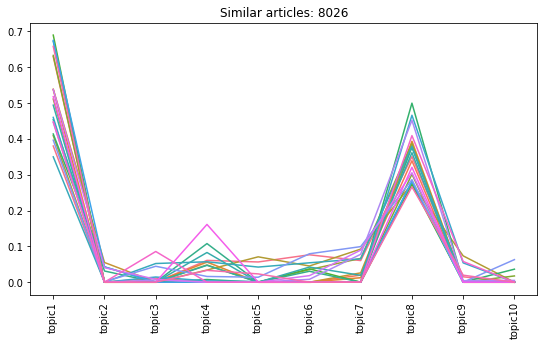

In [132]:
''' shows breakdown of articles closely related to aritcle 8026 in terms of topics '''
figure = plt.figure(figsize=(20,5))

figure.add_subplot(1, 2, 1)
ax1 = sns.lineplot(data = Hnorm.loc[:, article_sim_8026], dashes=False, legend=False)
ax1.set_xticklabels(Hnorm.index, rotation=90);
ax1.set_title('Similar articles: 8026')

plt.show()

The last row - article 161 is article 8026 from the NMF breakdown, i.e the article that we are looking for others that are highly correlated to it

From this dataframe we can see the original articles that were shown to have topics highly correlated to article 8026 (161 in original dataframe) along with their reliability labels. We can see that even though article 8026 is tagged as unrealiable, it was matched with primarily reliable news articles based on its topic vectors. This tells us that even though NMF is good at matching articles based on topic correlation, it cannot consistently tell us if unreliable news articles are correlated with other unreliable news articles more strongly than with reliable news articles. We can rely on NMF to show us how fake and real news articles differ in terms of topic vector breakdown which can show us subjects that are preferred by unreliable and reliable news articles. This allowing us to make the generalization that articles that focus primarily on certain topics may be more likely to be realiable than unreliable and vice versa. However we cannot come to any concrete conclusions about unreliable news being more strongly correlated with other unreliable news than with reliable news - i.e we cannot make any statements concerning causal relationships.

Below we go into more detailed analysis of only unreliable news topic breakdowns and only reliable news topic breakdowns to examine topics that are preferred by each of these categories, as well as the difference in topic vector breakdowns. 

#### NMF FAKE ONLY

In [133]:
bow_vectorizer_fake, bow_features_fake = bow_extractor(X_fake_train)
feature_names_fake = bow_vectorizer_fake.get_feature_names()
tfidf_trans_fake, tdidf_features_fake = tfidf_transformer(bow_features_fake)

In [134]:
X_fake = tdidf_features_fake.T

In [135]:
# Takes a long time
r = 10 # no. of topics
W_fake_topic10,H_fake_topic10 = \
    non_negative_marix_decomp(n_components = r, train_data = X_fake) 

H_fake_topic10 /= H_fake_topic10.sum(0)

In [136]:
extract_topic_top_words(W_fake_topic10, feature_names_fake)

# Topic 1
people 0.4478186091464003
world 0.3374496088434494
year 0.3017513153085715
like 0.2972955723458661
time 0.2920255120411662
just 0.27972027392044735
say 0.26402594410460617
make 0.2553408396227398
know 0.25019819921624054
government 0.2495921818442844
life 0.23824687877539769
work 0.22930120768717766
thing 0.22642068230029322
think 0.2183315907252295
don 0.2183045784039457
come 0.21794711896321017
gold 0.21041236317955195
need 0.2098097705025573
way 0.2075484664105753
child 0.2060913701071841


# Topic 2
fbi 1.670292129423744
comey 1.1137248420687227
email 0.8766649159240314
investigation 0.8702488925087356
weiner 0.4784876029520354
clinton 0.4322557307242385
director 0.38291638506085723
abedin 0.35172082751890166
letter 0.32558142584609834
reopen 0.28994102373845754
james 0.28112985362011134
huma 0.2721690200612227
server 0.25924614324434747
information 0.247438015298822
department 0.24351627059556205
hillary 0.23870176069206817
anthony 0.23337129790029562
congress 0.22289406

### Unreliable Article NMF Topic Categorization

- Topic 1: primarily random and common words in the news cycle - maybe in further analysis these words could be filtered out. (i.e people, say, American, news)
- Topic 2: conspiracy theory topics -  Huma Abedin, Comey, Fbi, Investigation
- Topic 3: Presidential/Elections - Trump, Obama, Clinton, campaign, election, rally
- Topic 4: Spanish words
- Topic 5: War & Security - mentions of Russia, Syria, and war all have high ranks, Putin, attack, and nuclear mentioned as well
- Topic 6: Words common to online text publishing (common words) - text, bold, cite, etc
- Topic 7: Dakota Pipeline Controversy
- Topic 8: Conspiracy (Clinton)- email, server, wikileaks, assange
- Topic 9: Social Media - Twitter, Facebook, comment, follow
- Topic 10: Elections - vote, election, poll, ballot, state, rig

In [137]:
num_topics, num_articles = H_fake_topic10.shape

H10df_fake = pd.DataFrame(H_fake_topic10, 
                     index=['topic'+str(one) for one in range(1, num_topics+1)], 
                     columns=['articles'+str(one) for one in range(1, num_articles+1)])
vec_normalize = lambda x: x / sum(x) 
Hnorm = H10df_fake.apply(vec_normalize, axis=0)

In [138]:
random_subset_fake = H10df_fake.sample(n=1000, replace = False, random_state=100, axis = 1)

In [139]:
#not very interesting, look at hierarchical clustering heat map instead
article_corr_fake = random_subset_fake.corr()

# %matplotlib inline

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(18,18))
# ax = sns.heatmap(article_corr_fake, square=True, cmap="coolwarm");

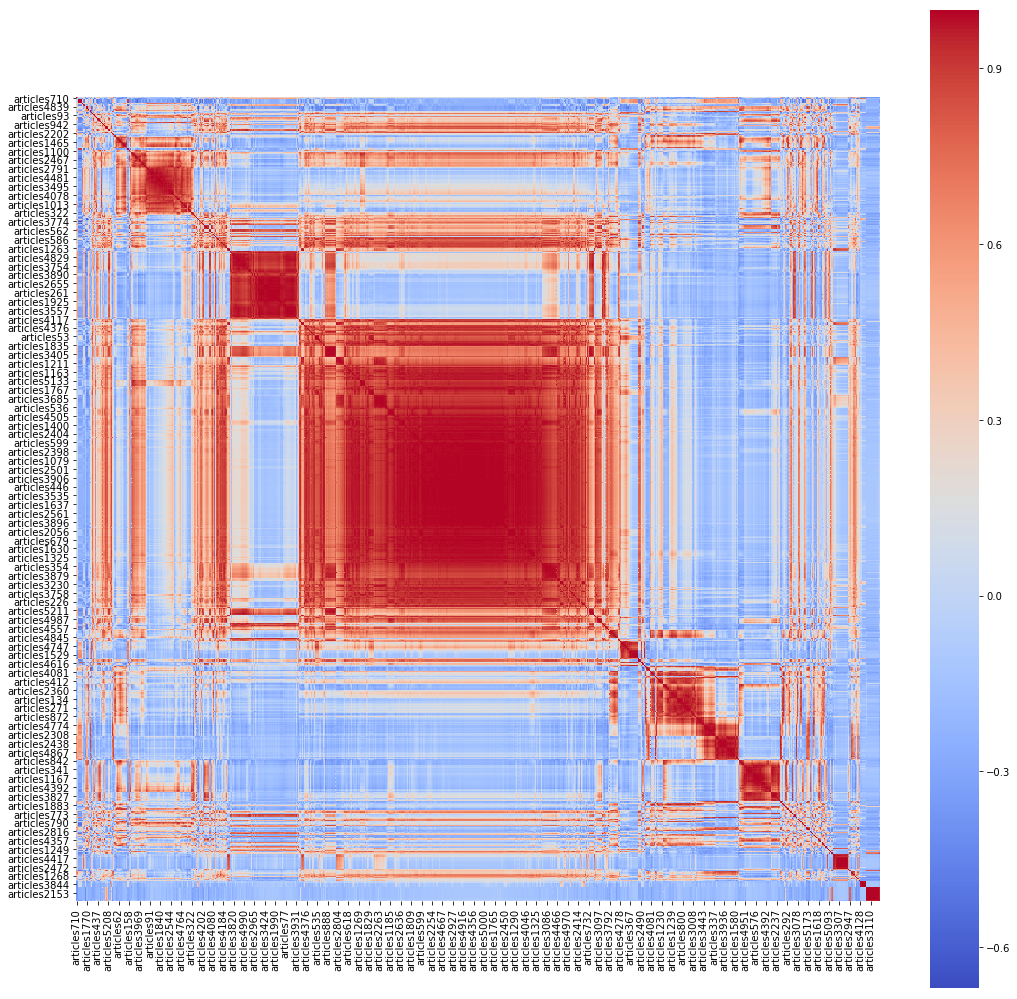

In [140]:
from scipy.cluster.hierarchy import linkage, leaves_list
review_linkage = linkage(article_corr_fake.transpose(), optimal_ordering=True)
leave_ord = leaves_list(review_linkage)

plt.figure(figsize=(18,18))
sns.heatmap(article_corr_fake.iloc[leave_ord, leave_ord], square=True, cmap="coolwarm")

In the unreliable news heatmap we see a stronger correlation between articles based on topic similarity than we saw with the heatmap for all articles (both unreliable and reliable)

Remove topic 1, topic 4, and topic 6 because topic 1 is all common words, topic 4 is all spanish words, and topic 6 seems to be words related to text formatting in the news articles - i.e bold, comment, text, cite, quote. 

In [141]:
no_topic_1 = H10df_fake.drop(['topic1'])
no_topic_6 = no_topic_1.drop(['topic6'])
no_topic_4 = no_topic_6.drop(['topic4'])

### Look at "Purity" of topics for fake news articles

i.e if we set the minimum limit for the article having to be composed at 95% by one topic, will there be fewer or more unreliable articles that fulfill this requirement than amongst all articles (186)

In [142]:
m2 = no_topic_4.gt(.95)
purity_fake = no_topic_4.loc[m2.any(axis=1), m2.any()]
purity_fake

articles34  articles45  articles71  articles92  articles123  \
topic2          0.0    0.018799    0.000000         0.0          0.0   
topic3          0.0    0.000000    0.000000         0.0          0.0   
topic5          0.0    0.977425    0.000000         0.0          0.0   
topic7          1.0    0.003171    0.982693         1.0          0.0   
topic8          0.0    0.000000    0.000000         0.0          0.0   
topic9          0.0    0.000605    0.000000         0.0          1.0   
topic10         0.0    0.000000    0.000000         0.0          0.0   

         articles126  articles261  articles341  articles389  articles463  ...  \
topic2      0.000000     0.002207          0.0      0.00000          0.0  ...   
topic3      0.000000     0.000000          0.0      0.00000          0.0  ...   
topic5      0.000000     0.977731          0.0      0.96667          0.0  ...   
topic7      0.986417     0.020062          0.0      0.00000          1.0  ...   
topic8      0.011862     0.000000          0.0      0.00000          0.0  ...   
topic9      0.000000     0.000000          0.0      0.03333          0.0  ...   
topic10     0.000000     0.000000          1.0      0.00000          0.0  ...   

         articles4996  articles5040  articles5090  articles5091  articles5134  \
topic2       0.016756           0.0      0.000000        0.0000      0.007251   
topic3       0.983244           0.0      0.005328        0.0000      0.000000   
topic5       0.000000           0.0      0.000000        0.0000      0.000000   
topic7       0.000000           0.0      0.006727        0.0000      0.982780   
topic8       0.000000           0.0      0.000000        0.0000      0.000000   
topic9       0.000000           0.0      0.952310        0.0000      0.005181   
topic10      0.000000           1.0      0.000000        0.9852      0.000000   

         articles5136  articles5152  articles5163  articles5187  articles5210  
topic2       0.025666      0.000000           0.0      0.000000      0.000000  
topic3       0.000000      0.000000           0.0      0.000000      0.957959  
topic5       0.950628      0.000000           0.0      0.972274      0.000000  
topic7       0.006037      0.000000           0.0      0.000000      0.000000  
topic8       0.000000      0.997997           0.0      0.000000      0.000000  
topic9       0.000000      0.002003           1.0      0.000000      0.000000  
topic10      0.000000      0.000000           0.0      0.000000      0.000000  

[7 rows x 112 columns]

In [143]:
test = purity_fake.transpose()

We can see that there are fewer "pure articles" - only 112 vs 186 for all news - amongst the fake news topic analysis, now let's look at what these articles that have high concentrations of one specific topic primarily focus on

We can see that most articles that have high purity levels focus on topics 5 and 7. This is interesting because topic 5 focuses primarily on controversial topics such as the war in Syria, Russia, the military, and foreign intelligence. Topic 7 focused primarily on the Dakota Access Pipeline protests which was a response to a hugely controversial decision to use Native American land to build an oil pipeline that posed many health risks to the people who lived there. This interesting because it seems for unreliable news, articles that did focus in on one point chose to discuss highly controversial and polarizing content. 

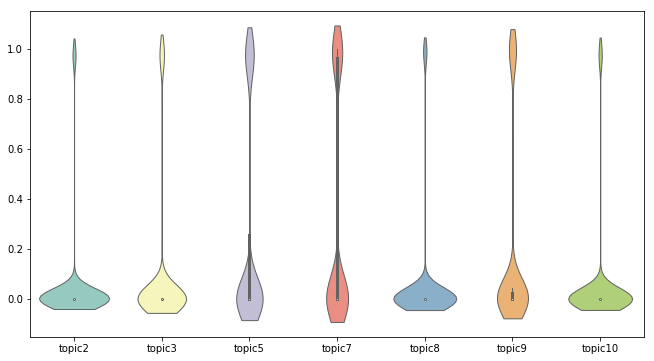

In [144]:
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=test, palette="Set3", bw=.2, cut=1, linewidth=1)

#### NMF REAL ONLY

In [145]:
bow_vectorizer_real, bow_features_real = bow_extractor(X_real_train)
feature_names_real = bow_vectorizer_real.get_feature_names()
tfidf_trans_real, tdidf_features_real = tfidf_transformer(bow_features_real)

In [146]:
X_real = tdidf_features_real.T

In [147]:
# Takes a long time
r = 10 # no. of topics
W_real_topic10,H_real_topic10 = \
    non_negative_marix_decomp(n_components = r, train_data = X_real) 

H_real_topic10 /= H_real_topic10.sum(0)

In [148]:
extract_topic_top_words(W_real_topic10, feature_names_real)

# Topic 1
say 0.5934081894545004
like 0.35783291666732814
woman 0.3310786003706774
time 0.3112398923538795
game 0.2961011653594042
people 0.2833537697746355
new 0.2681865381653357
just 0.26160592791481857
year 0.2581372350063114
want 0.24260840467129222
play 0.23813119427355853
think 0.2355594231068169
know 0.23552859022696046
don 0.22896853413576712
film 0.22280298829053255
make 0.20560874912638571
day 0.20311615146164572
life 0.1971279920732606
child 0.1950800205098801
work 0.1937814398484739


# Topic 2
mr 3.3536020282305423
clinton 0.9760898879315657
say 0.5693595071946488
trump 0.5242704100982803
republican 0.4027485762359054
campaign 0.39432580891646646
sander 0.2781080615405478
party 0.24731956462862198
voter 0.23416113465942964
candidate 0.20853601007887826
obama 0.20616967301981398
senator 0.17968832041138408
democratic 0.1699708540822765
nominee 0.15774855719983313
presidential 0.14855853417602338
convention 0.14650755452476716
election 0.14388931794268017
state 0.14317686313

### Reliable Article NMF Topic Categorization

- Topic 1: primarily random and common words in the news cycle - maybe in further analysis these words could be filtered out. (i.e people, say, American, news)
- Topic 2: Presidential Elections - Trump, campaign, Bernie, Obama, nominee, presidential
- Topic 3: Presidential Administration - White House, Donald Trump, Policy, Twitter
- Topic 4: War & Security - mentions of Russia, Syria, and war all have high ranks, Putin, attack, and nuclear mentioned as well
- Topic 5: Economic News - company, market, economy, growth
- Topic 6: Local(?) Law Enforcement - Texas, gun, crime, shoot, kill, police
- Topic 7: Healthcare - Obamacare, insurance, affordable, plan
- Topic 8: Conspiracy - Comey, leaked, FBI, investigation, Clinton, Hack
- Topic 9: Brexit 
- Topic 10: Immigration Policy & Law - appeal, immigration, case, Gorsuch 

In [149]:
num_topics, num_articles = H_real_topic10.shape

H10df_real = pd.DataFrame(H_real_topic10, 
                     index=['topic'+str(one) for one in range(1, num_topics+1)], 
                     columns=['articles'+str(one) for one in range(1, num_articles+1)])
vec_normalize = lambda x: x / sum(x) 
Hnorm = H10df_real.apply(vec_normalize, axis=0)
random_subset_real = H10df_real.sample(n=1000, replace = False, random_state=100, axis = 1)

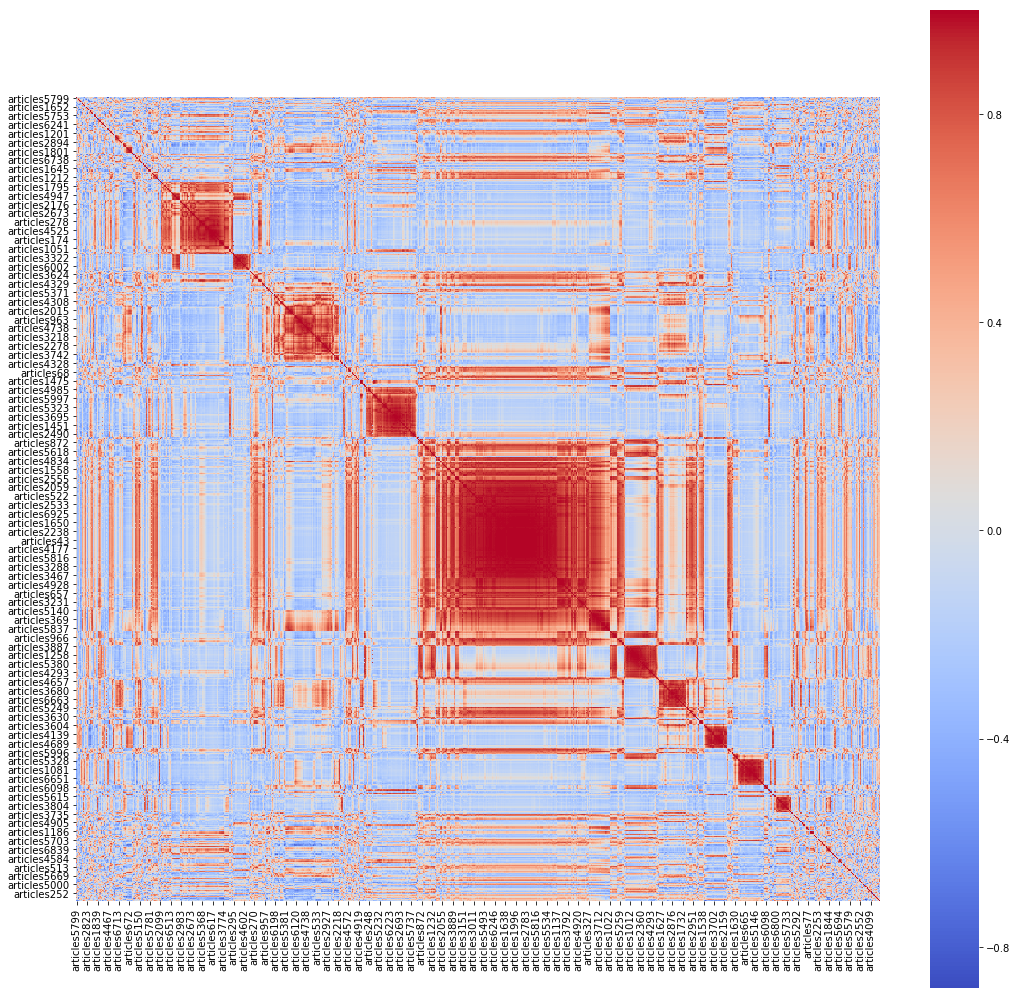

In [150]:
article_corr_real = random_subset_real.corr()

from scipy.cluster.hierarchy import linkage, leaves_list
review_linkage = linkage(article_corr_real.transpose(), optimal_ordering=True)
leave_ord = leaves_list(review_linkage)

plt.figure(figsize=(18,18))
sns.heatmap(article_corr_real.iloc[leave_ord, leave_ord], square=True, cmap="coolwarm")

When comparing this heatmap to that of the unreliable news heatmap, we see a weaker correlation between articles based on topic similarity

In [151]:
no_topic_1_real = H10df_real.drop(['topic1'])

### Look at "Purity" of topics for real news articles

i.e If we set the minimum limit for the article having to be composed at 95% by one topic, will there be fewer or more reliable articles that fulfill this requirement than unreliable articles (112)

In [152]:
m3 = no_topic_1_real.gt(.95)
purity_real = no_topic_1_real.loc[m3.any(axis=1), m3.any()]
purity_real

articles32  articles37  articles490  articles515  articles617  \
topic4     0.000000    0.000000          0.0     0.000000     0.000000   
topic5     0.000000    0.000000          0.0     0.000000     0.000000   
topic6     0.000000    0.000000          1.0     0.989069     0.959701   
topic7     0.000000    0.000000          0.0     0.000000     0.010218   
topic8     0.000000    0.000000          0.0     0.000000     0.000000   
topic9     0.000000    0.999635          0.0     0.010931     0.000000   
topic10    0.995308    0.000000          0.0     0.000000     0.000000   

         articles832  articles1031  articles1094  articles1100  articles1254  \
topic4      0.000000      0.000000      0.010206      0.000000      0.000000   
topic5      0.000000      0.000000      0.000000      0.000000      0.000000   
topic6      0.977439      0.983546      0.017896      0.000000      0.982051   
topic7      0.000000      0.000000      0.962743      0.000000      0.000000   
topic8      0.000000      0.000000      0.000000      0.000000      0.000000   
topic9      0.000000      0.000000      0.000000      0.000000      0.000000   
topic10     0.022561      0.000000      0.000000      0.981235      0.000000   

         ...  articles5865  articles6043  articles6300  articles6482  \
topic4   ...      0.000000           0.0      0.000000      0.000000   
topic5   ...      0.000000           0.0      0.043027      0.004318   
topic6   ...      0.000000           1.0      0.956973      0.000000   
topic7   ...      0.000000           0.0      0.000000      0.964316   
topic8   ...      0.956686           0.0      0.000000      0.021652   
topic9   ...      0.000000           0.0      0.000000      0.000000   
topic10  ...      0.002789           0.0      0.000000      0.009714   

         articles6576  articles6633  articles6665  articles6703  articles6816  \
topic4       0.000000           1.0      0.000000           0.0      0.000000   
topic5       0.000000           0.0      0.000000           1.0      0.000000   
topic6       0.000000           0.0      0.953897           0.0      0.000000   
topic7       0.962789           0.0      0.000000           0.0      0.000000   
topic8       0.005524           0.0      0.000000           0.0      0.000000   
topic9       0.000000           0.0      0.000000           0.0      0.966226   
topic10      0.000000           0.0      0.037579           0.0      0.000000   

         articles6924  
topic4            0.0  
topic5            0.0  
topic6            1.0  
topic7            0.0  
topic8            0.0  
topic9            0.0  
topic10           0.0  

[7 rows x 61 columns]

We can see that there are fewer "pure articles" - only 61 vs 112 for unreliable news - amongst the reliable news topic analysis. 

This may be due to the fact that reliable sources, or good journalism needs to talk about issues from multiple viewpoints in order to give a balanced review of a topic. Additionally reliable news may chose to focus on multiple issues within one article rather than just trying to drive the point home with one topic as their agenda is not to force a singular viewpoint upon a reader, but rather to provide a balanced overview of current events. 

Now let's look at what reliable articles that have high concentrations of one specific topic primarily focus on.

In [153]:
test_real = purity_real.transpose()

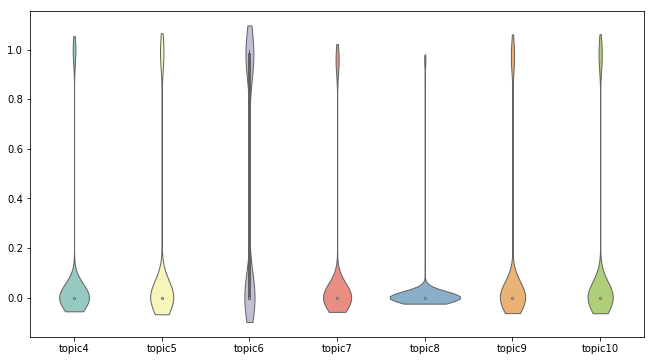

In [154]:
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=test_real, palette="Set3", bw=.2, cut=1, linewidth=1)

We can see from the violin plot that "pure" articles focus primarily on topic 6 which relates to local law enforcement and gun violence topics. This makes sense as unfortunately gun violence is a huge part of current events the news cycle due to its ubiquity in America. This is also interesting because gun violence is a hugely controversial topic, and based on the NMF analysis of fake news the majority of "pure" fake news articles focus on controversial topics, but gun violence did not even show up as a topic vector in our decomposition. This can be interpreted as there being more reliable news coverage of gun violence than unreliable news coverage. 

In [155]:
NMF_Breakdown = pd.DataFrame([('Common News Cycle Terms', 'Political Figures', 'Conspiracy Topics', 'Trump', 'War & Security',
                   'Local Politics/Immigration', 'Economy', 'Spanish Words', 'Healthcare'),
                       ('Common News Cycle Terms', 'Conspiracy Theories', 'Presidential Elections',
                       'Spanish Words', 'War & Security', 'Words Common to Online Publishing', 'Dakota Pipeline',
                       'Conspiracy (Clinton)', 'Social Media', 'Elections'),
                       ('Common News Cycle Terms', 'Presidential Elections', 'Presidential Adminstration',
                       'War & Security', 'Economic News', 'Gun Violence', 'Healthcare', ' Conspiracy',
                       'Brexit', 'Immigration')],
                      index=['All News NMF', 'Unreliable News NMF', 'Reliable News NMF'],
                     columns=('topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 'topic 6', 'topic 7', 'topic 8', 'topic 9', 'topic 10'))
NMF_Breakdown.transpose()

All News NMF                Unreliable News NMF  \
topic 1      Common News Cycle Terms            Common News Cycle Terms   
topic 2            Political Figures                Conspiracy Theories   
topic 3            Conspiracy Topics             Presidential Elections   
topic 4                        Trump                      Spanish Words   
topic 5               War & Security                     War & Security   
topic 6   Local Politics/Immigration  Words Common to Online Publishing   
topic 7                      Economy                    Dakota Pipeline   
topic 8                Spanish Words               Conspiracy (Clinton)   
topic 9                   Healthcare                       Social Media   
topic 10                        None                          Elections   

                   Reliable News NMF  
topic 1      Common News Cycle Terms  
topic 2       Presidential Elections  
topic 3   Presidential Adminstration  
topic 4               War & Security  
topic 5                Economic News  
topic 6                 Gun Violence  
topic 7                   Healthcare  
topic 8                   Conspiracy  
topic 9                       Brexit  
topic 10                 Immigration

As stated before NMF analysis is useful for showing relationship between articles in terms of their topic make up but does not allow us to make accurate statements concerning causal relationships between unreliable articles and other unreliable articles - i.e labels are not consistently related accross articles. (See example with article 8026 for context above)

However NMF analysis does show us interesting trends in terms of the types of topics that reliable news focuses on versus the types of topics unreliable news focuses on. For example when comparing the unreliable topic vectors with the reliable topic vectors we see that unreliable topic vectors include subjects such as "Dakota Pipeline", "Social Media", and 2 types of conspiracy theory topics whereas the reliable news topic vectors include no such mentions of social media or the Dakota Pipeline, and rather contain topics such as "Economic News", "Brexit", and "Healthcare". We hypothesize that this difference in topics is most likely due to the fact that it is easier to misconstrue highly polarizing topics, such as social media manipulation and the Dakota Pipeline - hence these topics' prescence in the unreliable news NMF analysis. Topics such as economic news and brexit in comparison are harder to "spin" and therefore probably not choosen as the topic of interest in news that intends to mislead its audience.

From our analysis of just unreliable news we can see that the preferred topics tend to be War & Violence, and the Dakota Pipeline - two highly polarizing issues. Contrastingly we can see with our analysis of just reliable news that the preferred topic is gun violence in America - somewhat surpising as this is also a highly controversial topic. We believe that this might be due to the fact that gun violence is a very common topic in the news cycle thus it is likely that there is just a large volume of news articles that discuss gun violence and therefore a disportionality large amount of reliable news articles that discuss gun violence.

Additionally we can see from the comparison of the unreliable news heatmap with the reliable news heatmap, that unreliable news articles tend to be more correlated to each other than reliable news articles. 

### Sentiment Analysis

In [57]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [58]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [59]:
cleaned_df = cleaned_df.reset_index(drop=True)

##### On the titles

In [ ]:
for i in range(0,18157):
    print(cleaned_df.title[i])
    score = sid.polarity_scores(cleaned_df.title[i])
    for k in sorted(score):
        print('{0}: {1}, '.format(k, score[k]), end='')
    print('\n')
    
; # long output

##### On the text

In [ ]:
for i in range(0,18157):
    print(cleaned_df.title[i])
    ss = sid.polarity_scores(cleaned_df.cleaned_data[i])
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print('\n')
    
; # long output

#### Extracting just the compound scores: 
We will be using the compound scores to analyze the sentiment in title and text since it provdes a summary of the overall sentiment (rather than separately analyzing the positive, negative, and neutral scores). The compound score determines the sum of all the lexicon ratings that were normalized between -1 (negative semtiment) and +1 (positive sentiment) ([source](https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/)).

positive sentiment : (compound score >= 0.05)

neutral sentiment : (compound score > -0.05) and (compound score < 0.05)

negative sentiment : (compound score <= -0.05)

We will take the differences of the compound scores for text and title as compound(text) - compound(title). Looking at their absolute values, if the difference is large, then title and text give different sentiment analyses. If the difference is small, then both title and text yield a similar sentiment within the article.

##### Difference the compound scores:

In [ ]:
# extract compound score differences (title vs text)
for i in range(0,18157):
    ss = sid.polarity_scores(cleaned_df.cleaned_data[i])
    score = sid.polarity_scores(cleaned_df.title[i])
    diff = abs(ss['compound'] - score['compound'])
    print(diff)
    
; # long output

In [63]:
# make lists of compound scores (useful for plotting/visualizations)
ss_list = []
score_list = []
compound_diff = []
for i in range(0,18157):
    ss = sid.polarity_scores(cleaned_df.cleaned_data[i])
    score = sid.polarity_scores(cleaned_df.title[i])
    ss_list.append(ss['compound'])
    score_list.append(score['compound'])
    compound_diff.append(abs(ss['compound'] - score['compound']))
    #print(compound_diff)

#### Visualizations for the Sentiment Analysis

We will use histograms to compare the compound score results for the text and title analyses of the articles

In [64]:
import seaborn as sns

##### First for text:

Text(0, 0.5, 'Frequency')

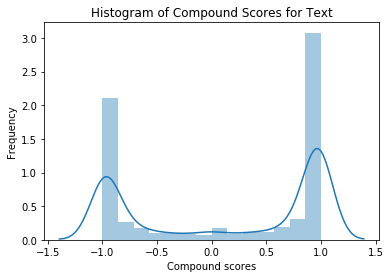

In [65]:
# histogram of text
sns.distplot(ss_list, axlabel = "Compound scores")
plt.title("Histogram of Compound Scores for Text")
plt.ylabel("Frequency")

##### Then for title:

Text(0, 0.5, 'Frequency')

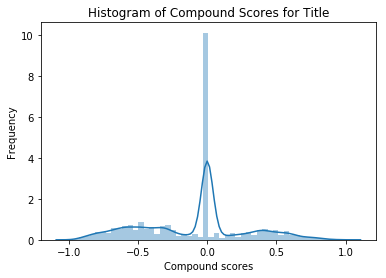

In [66]:
# histogram of title
sns.distplot(score_list, axlabel = "Compound scores")
plt.title("Histogram of Compound Scores for Title")
plt.ylabel("Frequency")

##### Compare the frequency of scores between titles and text.

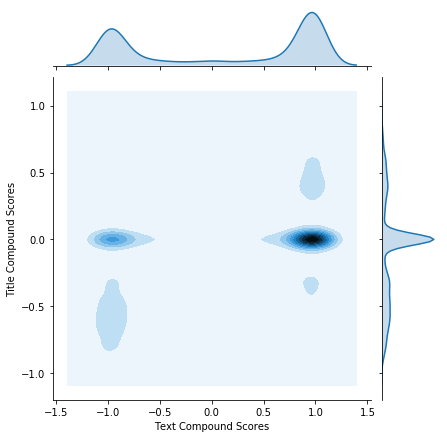

In [87]:
ax1 = sns.jointplot(x=ss_list, y=score_list, kind = "kde").set_axis_labels("Text Compound Scores", "Title Compound Scores")
plt.show()

We can see the from the third plot that the compound scores for both the title and text are highly concentrated around 0,-1, and 1 (which shows scores are well-defined and do not fall in-between 0 and 1 as often). We can see we have the highest concentration when the text compound scores are 1 and the title compound scores are 0.

The two histograms above that analyze compound scores (text and title respectively) show:

The distribution for the compound scores of the titles of articles is around 0, which suggests that many titles are neutral. This is a bit of an unexpected result because many titles are built to grab a reader's attention by using very emotional words. However, this could be due to the fact that titles (especially in comparison to the text of an article) are short, so there are not many words for the sentiment analysis to be performed upon.

In contrast, the distribution of compound scores for the text of the article is mostly around -1 and 1, which means that many texts are either very negative or very positive. The strong sentiments that come through in these results may be due to the fact that there is a lot more data (words) to be analyzed in the text of an article.

A possible flaw of our sentiment analysis is that it requires large amounts of data in order to draw clear conclusions. It is not as sensitive to sentiment when there are only a few words to analyze. Clearly, when there are fewer words, then there are fewer emotions to analyze. However, there also remains the possibility that there is some truth to the difference in distributions when it comes to titles and text. In comparison to the text of an article, the sentiment of a title may very well be neutral. A possible explanation is that sometimes the words a title contains are ones that we find interesting (such as a certain name), but are not necessarily marked as very positive or negative when it comes to sentiment. In addition, titles are sometimes used as a method to convey as much info in as few words as possible. Thus, when the goal of a title is to be informative, less sentimental words may be used.

#### Analyzing the difference in compound scores to see if there is a difference in sentiment between reliable and unreliable news

In [77]:
compound_df = []
for i in range(0,18157):
    ss = sid.polarity_scores(cleaned_df.cleaned_data[i])
    score = sid.polarity_scores(cleaned_df.title[i])
    compound_df.append({'Compound Score': ss['compound'] - score['compound'], 'Title': cleaned_df.title[i], 'Label':
        cleaned_df.label[i]})
    #compound_df = pd.DataFrame(np.array(ss['compound'] - score['compound'], cleaned_df.title[i], cleaned_df.label[i], ss['compound'] - score['compound']))
    #print(compound_df)
compound_df = pd.DataFrame(compound_df)


Compound Score  Label  \
0             -0.5423      1   
1              0.8529      0   
2              1.3153      1   
3             -0.3281      1   
4             -0.1521      1   
5              0.4967      0   
6              0.4256      0   
7              0.6342      0   
8              0.7722      0   
9             -0.7522      0   
10            -0.9485      1   
11             0.0697      1   
12             0.4864      1   
13             0.4269      0   
14            -1.2347      0   
15            -0.4778      1   
16             0.9287      1   
17             0.9764      0   
18            -0.2247      0   
19            -0.4259      0   
20            -1.2617      0   
21            -0.1624      1   
22             1.1199      0   
23             1.4499      1   
24            -0.2558      0   
25             0.9994      0   
26             1.1568      0   
27             0.4194      0   
28             0.9960      0   
29             1.4175      0   
...               ...    ...   
18127          0.9979      0   
18128          0.8020      1   
18129          0.6841      1   
18130          0.1531      1   
18131          1.3001      1   
18132          0.7906      0   
18133          0.0114      1   
18134         -1.2676      1   
18135         -0.7632      1   
18136          0.9945      0   
18137         -0.5918      0   
18138         -0.3066      0   
18139          0.3185      1   
18140          0.6582      1   
18141         -0.9817      0   
18142         -1.4874      1   
18143          0.2857      0   
18144          0.7717      0   
18145          1.4961      1   
18146          0.1733      0   
18147         -0.9960      0   
18148          0.9884      1   
18149         -0.4556      0   
18150         -0.2308      1   
18151          0.9607      0   
18152          0.3612      0   
18153          0.9921      0   
18154          0.9891      0   
18155          0.2500      1   
18156         -1.3761      1   

                                                   Title  
0      House Dem Aide: We Didn’t Even See Comey’s Let...  
1      FLYNN: Hillary Clinton, Big Woman on Campus - ...  
2                      Why the Truth Might Get You Fired  
3      15 Civilians Killed In Single US Airstrike Hav...  
4      Iranian woman jailed for fictional unpublished...  
5      Jackie Mason: Hollywood Would Love Trump if He...  
6      Benoît Hamon Wins French Socialist Party’s Pre...  
7      A Back-Channel Plan for Ukraine and Russia, Co...  
8      Obama’s Organizing for Action Partners with So...  
9      BBC Comedy Sketch "Real Housewives of ISIS" Ca...  
10     Russian Researchers Discover Secret Nazi Milit...  
11     US Officials See No Link Between Trump and Russia  
12     Re: Yes, There Are Paid Government Trolls On S...  
13     In Major League Soccer, Argentines Find a Home...  
14     Wells Fargo Chief Abruptly Steps Down - The Ne...  
15     Anonymous Donor Pays $2.5 Million To Release E...  
16                             FBI Closes In On Hillary!  
17     Chuck Todd: ’BuzzFeed Did Donald Trump a Polit...  
18     Monica Lewinsky, Clinton Sex Scandal Set for ’...  
19     Rob Reiner: Trump Is ’Mentally Unstable’ - Bre...  
20     Abortion Pill Orders Rise in 7 Latin American ...  
21     Nukes and the UN: a Historic Treaty to Ban Nuc...  
22     EXCLUSIVE: Islamic State Supporters Vow to ‘Sh...  
23     Humiliated Hillary Tries To Hide What Camera C...  
24     Andrea Tantaros of Fox News Claims Retaliation...  
25     How Hillary Clinton Became a Hawk - The New Yo...  
26     Chuck Todd to BuzzFeed EIC: ’You Just Publishe...  
27     Having Won, Boris Johnson and ‘Brexit’ Leaders...  
28     Texas Oil Fields Rebound From Price Lull, but ...  
29     Bayer Deal for Monsanto Follows Agribusiness T...  
...                                                  ...  
18127  President Trump’s Father’s Day Proclamation: D...  
18128  Former Ambassador Andrew Young Calls for End t...  
18129       WORL

After gathering a dataframe with the compound scores from the sentiment analysis, along with the labels of reliable and unreliable for each article, we can plot the compound scores and labels to see if there is a difference in compound scores when it comes to reliable versus unreliable articles. 

In [78]:
# extracting the unreliable vs reliable articles
unreliable = compound_df.loc[(compound_df['Label'] == 1)]
unreliable = unreliable.iloc[:,0]

reliable = compound_df.loc[(compound_df['Label'] == 0)]
reliable = reliable.iloc[:,0]

Text(0, 0.5, 'Frequency')

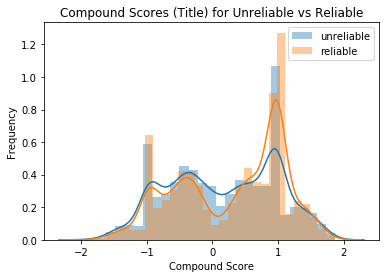

In [79]:
# multiple lines chart to compare unreliable vs reliable compound scores
ax = sns.distplot(unreliable, axlabel = "Compound scores", label = 'unreliable')
ax = sns.distplot(reliable, label = 'reliable')
ax.legend()
plt.title("Compound Scores (Title) for Unreliable vs Reliable")
plt.ylabel("Frequency")

When comparing the compound scores of unreliable versus reliable articles in the plot above, we can see that the largest difference occurs when compound score = 1. This shows that reliable articles are slightly more likley than unreliable articles to have positive sentiment in the title. In addition, reliable articles are slightly less likely than unreliable ones to have a compound score of 0 (which equates to neutral sentiment). Negativity in unreliable article titles could be explained by a need to create a strong emotion like fear in order to grab a reader's attention and spread fake news. However, the differences in the plot above are not very large and thus indicate that differences in the sentiment of unreliable versus reliable articles are not large enough to be used as an indicator of reliability. In oher words, there isn't a large enough difference in title sentiment to use it to determine whether an article is reliable. 

#### DISCUSSION OF RESULTS

Our analysis focused on finding the most common topics/words associated with “fake news” and recording their frequencies to see if there are any patterns. We found the sentiments associated with “fake news” articles (by looking at the positive/negative valence of certain words). In general, a large portion of our analysis focused on labeling news and sources as fake or not with as high of an accuracy as possible. We realized from the sentiment analysis that many of the titles were neither positive or negative, likely because they were short titles so there was not enough words to create a decisive positive or negative decision. On the contrary, the text was either very positive or very negative.

#### POSSIBLE IMPROVEMENTS/FUTURE DIRECTIONS

Some potential future directions are examining if the credibility of news is affected by the social media platform it was shared on, or if it is possible to determine the credibility of an article based on it’s communication path (i.e who shares the news). In other words, it would be interesting to see if certain people or sources that share news are reliable, and if that reliability at all depends on other factors (such as the topic of the article shared).

Our models (as analyzed by the confusion matrices) all had high accuracy which lead us to believe that future analysis should carefully ensure there is no overfitting. Further analysis should include a more detailed cross-validation of the models, and a search for optimal parameters, in order to ensure the models are both accurate and have no issues with overfitting. 

Finally, we think that an interesting future direction could be to look for other indicators for the reliability of a news articles. While we focused on common topics and sentiment, there could be other areas to draw patterns from. One such possible area is look at the location of the news/news source and break it down by political regions to see if there are any patterns.

#### CONCLUSION

- Modeling

	- We had fairly high accuracy models which we are happy with. However, we do want to note that overfitting may be a concern. While we did do some basic cross-validation by comparing the predicted labels of several articles to the original labels, more analysis could be done to ensure that overfitting is not a real issue.
    
- NMF
    - NMF analysis showed us that articles could be grouped together well by correlation of topics, however no causal relationships can be made concerning article reliability labels and their topic makeup. We see that unreliable news articles tend to favor coverage of highly controversial topics - most likely because these are easier to spin and can be used to effectively polarize an audience. We found that reliable news article tend to favor coverage of slightly less controversial topics such as economic news, healthcare, Brexit. We also find that there is a larger proportion of unreliable news topics that focus in soley on one topic (see purity tests for context) indicating that unreliable news does not present multiple view points, rather it trends towards focusing on one controversial topic and driving that idea home. Conversly a smaller proportion of reliable news articles focus soley on one topic, which we believe is due to the fact that "good" journalism must look at a issue from multiple angles and therefore incoporates more topics into the article. 
    
- Sentiment Analysis

	- A comparison of text and title sentiment showed that text sentiment is either very positive or negative, while title sentiment is very neutral. We noted that the neutrality of title sentiment could be do to its short nature and the fact there are not many words to analyze. A comparison of compound scores for reliable and unreliable articles showed that there are no strong differences between the two when it comes to sentiment (the fact that reliable articles are slightly more likely to have positive sentiment was not very significant). This illustrates that sentiment may not be a clear indicator of reliability. It is possible that future sentiment analysis could section the data even further than reliable versus unreliable (perhaps by common topics), in order to see if there are any other patterns in sentiment.
    
- Did we meet our goals?

	- Overall, we are satisfied with the results. We were able to identify fairly accurate models for labeling news as "reliable" and "unreliable." We also identified interesting common topics and showed patterns in sentiment analysis. In our search for patterns in fake news, the qualitative analysis has shown us that the characteristics of unreliable news are rather murky not well defined. There is always a grey area in the analysis, since so many factors play a role in identifying fake news. Not only do sources debate on what types of articles should be considered fake news, but we also have to consider the fact the very nature of news is to capture a reader's attention. Sometimes this means catering towards the audience rather than towards the facts, which makes the lines between reliable and unreliable news blur. Perhaps there are no large differences in sentiment between reliable and unreliable news because both types are hoping to draw a reaction. This is why further analysis should focus on finding other areas where fake news differs, beyond topic and sentiment. We have come to realize that identifying fake news is a complicated topic, involving many factors, but that we are still able to draw interesting patterns and characteristics in news that could help us with solving the fake news issue in the future.


#### References

- https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html

- Credit for this function goes to Ravish Chawla - found on his Github repo concerning nmf analysis for ABC news headlines---https://gist.github.com/ravishchawla/3f346318b85fa07196b761443b123bba

- https://github.com/venkateshgupta5/Fake-News/blob/master/Fake%20News%20Classifier.ipynb

- http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

- https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#evaluation-of-the-performance-on-the-test-set

- https://github.com/docketrun/Detecting-Fake-News-with-Scikit-Learn/blob/master/Comparing%20Fake%20News%20Classifiers.ipynb

- https://github.com/docketrun/Detecting-Fake-News-with-Scikit-Learn/blob/master/Comparing%20Fake%20News%20Classifiers.ipynb

- https://www.datacamp.com/community/tutorials/scikit-learn-fake-news

- https://github.com/several27/FakeNewsCorpus

- https://github.com/vcabales/fake-news-classifier/blob/master/Fake%20News%20Analysis.ipynb

- https://opendatascience.com/how-to-build-a-fake-news-classification-model/

- https://github.com/Cisco-Talos/fnc-1/blob/master/tree_model/README.md